In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-21 12:16:29.777699: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 12:16:29.788011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761041789.801728 1041661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761041789.806260 1041661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-21 12:16:29.819643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

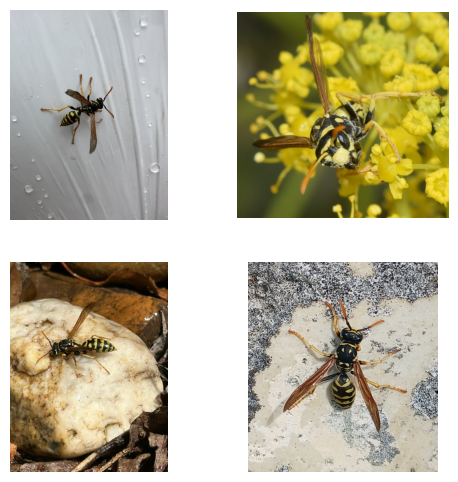

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 10989 images belonging to 127 classes.
Found 2726 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [8]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
#for layer in base_model.layers:
#    layer.trainable = False


"""
# Unfreeze the last N trainable convolutional blocks
trainable = False
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        if N == 0:
            break
        N -= 1
        trainable = True
    layer.trainable = trainable
"""

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_1041661/3838958738.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1761041793.874966 1041661 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761041793.876125 1041661 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45132 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 12,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761041803.424911 1041920 service.cc:148] XLA service 0x7b751c004120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761041803.424946 1041920 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761041803.424954 1041920 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-21 12:16:43.661667: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761041804.558797 1041920 cuda_dnn.cc:529] Loaded cuDNN version 91200
E0000 00:00:1761041806.290654 1041920 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041806.415679 1041920 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. T

317/344 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.0693 - loss: 4.5993

E0000 00:00:1761041868.608681 1041919 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041868.733078 1041919 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041871.318514 1041919 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041871.442275 1041919 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041873.119336 1041919 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.0745 - loss: 4.5578

E0000 00:00:1761041896.900868 1041922 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041897.025642 1041922 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041899.529046 1041922 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041899.673039 1041922 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761041899.796300 1041922 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_average_precision = 0.3090
344/344 ━━━━━━━━━━━━━━━━━━━━ 127s 302ms/step - accuracy: 0.1412 - loss: 4.0339 - val_accuracy: 0.3092 - val_loss: 2.9888 - val_average_precision: 0.3090 - learning_rate: 1.0000e-04
Epoch 2/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3991 - loss: 2.4957
Epoch 2: val_average_precision = 0.4392
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - accuracy: 0.4169 - loss: 2.3628 - val_accuracy: 0.4101 - val_loss: 2.2926 - val_average_precision: 0.4392 - learning_rate: 1.0000e-04
Epoch 3/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5818 - loss: 1.6000
Epoch 3: val_average_precision = 0.4930
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.5833 - loss: 1.5738 - val_accuracy: 0.4813 - val_loss: 1.9928 - val_average_precision: 0.4930 - learning_rate: 1.0000e-04
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7199 - loss: 1.0673
Epoch 4: val_average_precision = 0.5165
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.7162 - loss: 1.0599 - val_accuracy: 0.4971 - val_loss: 1.9296 - val_average_precision: 0.5165 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8301 - loss: 0.6814
Epoch 5: val_average_precision = 0.5217
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.8212 - loss: 0.6928 - val_accuracy: 0.5066 - val_loss: 1.8942 - val_average_precision: 0.5217 - learning_rate: 1.0000e-04
Epoch 6/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9073 - loss: 0.4155
Epoch 6: val_average_precision = 0.5219
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.8967 - loss: 0.4311 - val_accuracy: 0.5033 - val_loss: 1.9481 - val_average_precision: 0.5219 - learning_rate: 1.0000e-04
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9462 - loss: 0.2638
Epoch 7: val_average_precision = 0.5167
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 233ms/step - accuracy: 0.9402 - loss: 0.2737 - val_accuracy: 0.4989 - val_loss: 2.0232 - val_average_precision: 0.5167 - learning_rate: 1.0000e-04
Epoch 8/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9737 - loss: 0.1574
Epoch 8: val_average_precision = 0.5151
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 233ms/step - accuracy: 0.9686 - loss: 0.1702 - val_accuracy: 0.5026 - val_loss: 2.0973 - val_average_precision: 0.5151 - learning_rate: 1.0000e-04
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9854 - loss: 0.1059
Epoch 9: val_average_precision = 0.5179

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 241ms/step - accuracy: 0.9826 - loss: 0.1106 - val_accuracy: 0.5018 - val_loss: 2.0960 - val_average_precision: 0.5179 - learning_rate: 1.0000e-04
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9923 - loss: 0.0674
Epoch 10: val_average_precision = 0.5274
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 240ms/step - accuracy: 0.9936 - loss: 0.0638 - val_accuracy: 0.5264 - val_loss: 2.0353 - val_average_precision: 0.5274 - learning_rate: 5.0000e-05
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9934 - loss: 0.0494
Epoch 11: val_average_precision = 0.5275
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.9953 - loss: 0.0477 - val_accuracy: 0.5242 - val_loss: 2.0512 - val_average_precision: 0.5275 - learning_rate: 5.0000e-05
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9983 - loss: 0.0379
Epoch 12: val_average_precision = 0.5299
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 234ms/step - accuracy: 0.9973 - loss: 0.0395 - val_accuracy: 0.5293 - val_loss: 2.0780 - val_average_precision: 0.5299 - learning_rate: 5.0000e-05


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


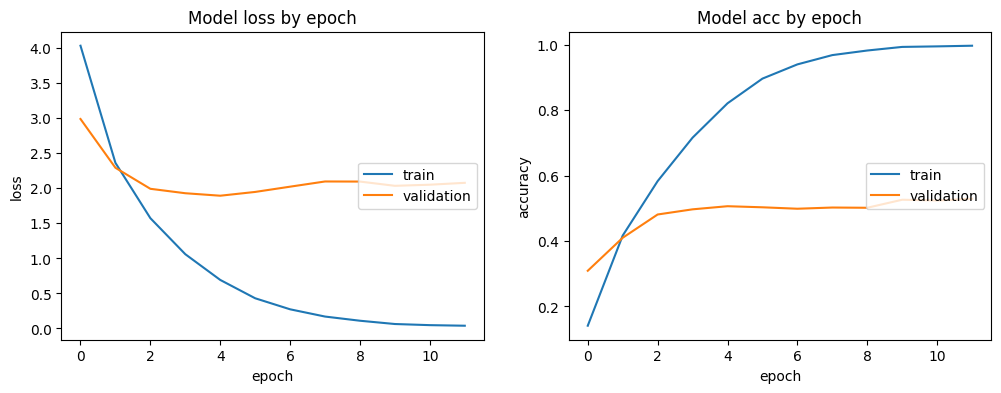

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [16]:
model.save('../models/model_127_species_exp3.h5')